In [1]:
#%pip install torch
#%pip install torchquad
#%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
# sympy we'll use for deriving the physics problem of dropping a magnet through loop of wire
import sympy as smp
import matplotlib.pyplot as plt
# This is the main library for today, Torchquad, same as scipy.quad
#  but built on torch functionality for different integration techniques
from torchquad import Simpson, set_up_backend
from scipy.integrate import nquad   # we compare to nquad
import inspect      # used for a little hack
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# this set_up_backend function is used to setup that the GPU is used
set_up_backend("torch", data_type="float32")

cuda


c:\Programming\anaconda3\Lib\site-packages\torch\__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


# torchquad vs. SciPy Basic Usage

Integrate $f(x_1,x_2,x_3,x_4,x_5)=\sum_{i=1}^5 \sin(x_i)$ from 0 to 1 in each of the $x_i$:

$$\int_0^1...\int_0^1 \sum_{i=1}^5 \sin(x_i) dx_1dx_2dx_3dx_4dx_5$$

We know the ground truth (the analytical solution) of this integral is $10\sin^2(1/2)$ 

* The NumPy integrand function needs to take in 5 arguments. By using `*x` as input, it will automatically take all the input arguments to that function and turn it into a tuple. It returns a single number.
* The PyTorch integrand function takes in a tensor of shape `[n_points, n_dimensions]` and outputs a tensor of shape `[n_points]` (the value of the integrand at each integration point). That is why we sum along `dim=1` in the pytorch integrand function

In [2]:
def f(*x):
    print(type(x))
    return x

In [3]:
"""
<class 'tuple'>
(1, 2, 3, 5, 45, 65, 34, 45, 45)

*x places all passed arguments into a tuple 

The advantage of that for the integrand functions, you can turn it into a
 function (in this case the integrand_numpy) takes in 5 arguments and returns
 a sum of sines of all the values, and returns 1 single value
 
The Pytorch function is a little bit different, it takes in x which in this case
 is a tensor of shape [n_points, n_dimensions], the n_points are all the
 discrete values of x at which the function is going to be evaluated at / integrated
 In essence it's doing the same as the numpy one but it's doing it for every single
 point in the integration domain
We sum over dim=1 because we want to sum over the dimensions of x [n_points, n_dimensions]
 n_dimensions is in the indeks 1, it returns the [n_points] tensor
"""
f(1,2,3,5,45,65,34,45,45)

<class 'tuple'>


(1, 2, 3, 5, 45, 65, 34, 45, 45)

In [4]:
"""
You'd use TorchQuad for high dimensionality integration problems

You have to setup the integrand (f(x)) function correctly for each library
Read the thing above
"""

def integrand_numpy(*x):
    return np.sum(np.sin(x))
def integrand_pytorch(x):
    return torch.sum(torch.sin(x), dim=1)

Let's compare how long they take to run

In [5]:
dimension = 5
integration_domain = [[0, 1]] * dimension
ground_truth = 2 * dimension * np.sin(0.5)**2   # analytic solution

In [6]:
ground_truth

2.2984884706593016

* NumPy/Scipy (CPU)

In [7]:
# the CPU numpy version, we pass integrand and the domain \in [0, 1]
#  in each dimensions (x_i; i=1-5)
# [0] gives value of the evaluation, [1] gives the estimate of the error
result_numpy = nquad(integrand_numpy, integration_domain)[0]
# took 1m 24.4s
# for him this took 15s ahahhaha
# for me this time took 2m 23.4s

* PyTorch/TorchQuad (GPU)

In [8]:
%%timeit    # this is for timing the execution time
# In this case you need to specify the total amount of points you want to use
#  in the integration domain, 37^dimensions stands for 37 points in each x_i dimension
N = 37 ** dimension
#N = 15 ** dimension
simp = Simpson()  # Initialize Simpson solver
# We once again pass the integrand, the dim is dimensions is 5 dimensional,
#  the N stands for number of points to integrate over, and of course integration domain
result_pytorch = simp.integrate(integrand_pytorch, dim=dimension, N=N, integration_domain=integration_domain)
# took 6.64 ms per loop, total 0.5s
# took 0.0s for him, says subsequent runs take less because it's already setup on GPU
# took 19.5s this time (with the 37^dimensions)
# another time it took 10s
print(f'PyTorch/TorchQuad: {result_pytorch:.6f}')
# why the fuck did it run 8 times? and then become undefined

c:\Programming\anaconda3\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Programming\anaconda3\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


PyTorch/TorchQuad: 2.298488
PyTorch/TorchQuad: 2.298488
PyTorch/TorchQuad: 2.298488
PyTorch/TorchQuad: 2.298488
PyTorch/TorchQuad: 2.298488
PyTorch/TorchQuad: 2.298488
PyTorch/TorchQuad: 2.298488
PyTorch/TorchQuad: 2.298488
106 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that they are both exactly equal to the ground truth

In [9]:
print(f'Ground Truth: {ground_truth:.6f}')
print(f'NumPy/Scipy: {result_numpy:.6f}')
print(f'PyTorch/TorchQuad: {result_pytorch:.6f}')

Ground Truth: 2.298488
NumPy/Scipy: 2.298488


NameError: name 'result_pytorch' is not defined

# A More Interesting Physics Use Case

This problem requires fast integration

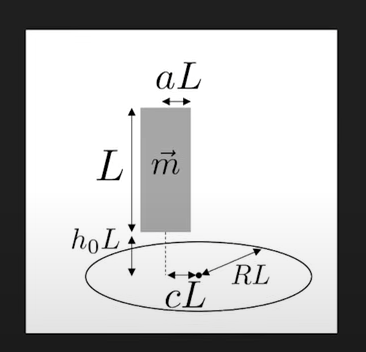

In [10]:
%matplotlib inline
from IPython.display import Image
Image('C:/Programming/Tutorials/GPUPython/vidIntegration.PNG')

<p align="left">
  <img src="../images/magnet_fall.PNG" alt="drawing" width="200" align="center"/>
</p>

A cylindrical bar magnet of total magnetization $\vec{m}$ (isotropic, pointing in $\hat{z}$) is falling through a loop of wire. Due to the changing magnetic flux in the loop, a current $I$ is induced. Find the current as a function of time $t$ if the magnet has the dimensions above and is dropped from an initial height $h_0L$.

Note that

$$I(t) = - \frac{\partial \Phi}{\partial t} = -\frac{\partial}{\partial t} \iint_{\text{loop}} \vec{B} \cdot d\vec{\sigma} = -\frac{\partial}{\partial t} \iint_{\text{loop}} (\nabla \times \vec{A}) \cdot d\vec{\sigma} = -\frac{\partial}{\partial t} \oint_{\text{loop}} \vec{A} \cdot d\vec{r} = -\oint_{\text{loop}}\frac{\partial \vec{A}}{\partial t} \cdot d\vec{r}$$

So we just need to find $\vec{A}$ from the bar magnet as a function of time and then $\frac{\partial \vec{A}}{\partial t}$. 

&nbsp;<br>

* If the bar magnet has total magnetization $m\hat{z}$ then it has density $\vec{M} = \frac{m}{\pi a^2 L^3} \hat{z}$

&nbsp;<br>

* The position of some point on the current loop is $\vec{r}(\phi) = \left<RL\cos(\phi),~RL\sin(\phi),~0\right>$

&nbsp;<br>

* The position of some point on the bar magnet is $\vec{r}'(r',z',\phi') = \left<r'\cos(\phi'),~r'\sin(\phi'),~h(t)+z'\right>$ where $h(t)$ corresponds to the bottom $z$ coordinate of the magnet, given by $h(t) = h_0L - \frac{1}{2}gt^2$

&nbsp;<br>

* The contribution to $d\vec{A}$ from a dipole is $d\vec{A} = \frac{\mu_0}{4 \pi} \frac{\vec{M} \times (\vec{r}-\vec{r}')}{|\vec{r}-\vec{r}'|^3} d\tau = \frac{\mu_0 m }{4 \pi L^3 a^2} \frac{\hat{z} \times (\vec{r}-\vec{r}')}{|\vec{r}-\vec{r}'|^3} d\tau$. This needs to be integrated over the entire cylinder to get $\vec{A} = \iiint_{\text{magnet}} d\vec{A}$

&nbsp;<br>

The total integral is expressed as the following (using $d\vec{A} = \frac{d\vec{A}}{d\tau} d\tau$ and $d\vec{r} = \frac{d\vec{r}}{d\phi} d\phi$,  and also using $d\tau = r'dr'd\phi'dz'$

$$I(t) = -\oint_{\text{loop}} \iiint_{\text{magnet}}\frac{\partial}{\partial t} \left(\frac{d\vec{A}}{d\tau} \cdot \frac{d\vec{r}}{d\phi}\right) r' d\phi dr' d\phi'  dz' = -\int_{0}^{2\pi} \int_{0}^{aL} \int_0^{2\pi} \int_{0}^L \frac{\partial}{\partial t} \left(\frac{d\vec{A}}{d\tau} \cdot \frac{d\vec{r}}{d\phi}\right) r' d\phi dr' d\phi'  dz'$$

We will instead solve for $\bar{I} = \frac{4 \pi^2 L^2}{\mu_0 m}I$ as a function of $\bar{t} = \sqrt{g/L} \cdot t$, as this makes both quantities dimensionless. In the expression below, all distances are expressed in units of $L$, and $d\vec{A}/d\tau$ now refers to $\frac{1}{a^2}\frac{\hat{z} \times (\vec{r}-\vec{r}')}{|\vec{r}-\vec{r}'|^3}$

$$\bar{I}(\bar{t}) = -\int_{0}^{2\pi} \int_{0}^{a} \int_0^{2\pi} \int_{0}^1 \frac{\partial}{\partial t} \left(\frac{d\vec{A}}{d\tau} \cdot \frac{d\vec{r}}{d\phi}\right) r' d\phi' dr' d\phi  dz'$$

We can obtain this expression below using Sympy:

In [11]:
# Instead of deriving this whole expression we just use sympy for it to get all the symbols
R, phi, rp, phip, zp, t, h0, a, R, c = smp.symbols('r \phi r\' \phi\' z\' t h_0 a R c', real=True)

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\legom\AppData\Local\Temp\ipykernel_7788\3172280121.py:2: SyntaxWarning: invalid escape sequence '\p'
  R, phi, rp, phip, zp, t, h0, a, R, c = smp.symbols('r \phi r\' \phi\' z\' t h_0 a R c', real=True)


In [12]:
# It returns a symbolic expression for the variables:
phi**2 + rp
# it literally prints \phi^2 + r'

\phi**2 + r'

Define the height $h(t)$

In [13]:
h = h0 - smp.Rational(1,2) * t**2

In [14]:
h

h_0 - t**2/2

In [17]:
r_vec - rp_vec 

Matrix([
[R*cos(\phi) - c - r'*cos(\phi')],
[    R*sin(\phi) - r'*sin(\phi')],
[             -h_0 + t**2/2 - z']])

In [18]:
dAdTau

Matrix([
[   (-R*sin(\phi) + r'*sin(\phi'))/(a**2*((R*sin(\phi) - r'*sin(\phi'))**2 + (h_0 - t**2/2 + z')**2 + (-R*cos(\phi) + c + r'*cos(\phi'))**2)**(3/2))],
[(R*cos(\phi) - c - r'*cos(\phi'))/(a**2*((R*sin(\phi) - r'*sin(\phi'))**2 + (h_0 - t**2/2 + z')**2 + (-R*cos(\phi) + c + r'*cos(\phi'))**2)**(3/2))],
[                                                                                                                                                  0]])

In [19]:
dr_vecdphi

Matrix([
[-R*sin(\phi)],
[ R*cos(\phi)],
[           0]])

In [20]:
integrand

r'*(3*R*t*(-R*sin(\phi) + r'*sin(\phi'))*(h_0 - t**2/2 + z')*sin(\phi)/(a**2*((R*sin(\phi) - r'*sin(\phi'))**2 + (h_0 - t**2/2 + z')**2 + (-R*cos(\phi) + c + r'*cos(\phi'))**2)**(5/2)) - 3*R*t*(h_0 - t**2/2 + z')*(R*cos(\phi) - c - r'*cos(\phi'))*cos(\phi)/(a**2*((R*sin(\phi) - r'*sin(\phi'))**2 + (h_0 - t**2/2 + z')**2 + (-R*cos(\phi) + c + r'*cos(\phi'))**2)**(5/2)))

Find the integrand:

In [16]:
r_vec = smp.Matrix([R*smp.cos(phi), R*smp.sin(phi), 0])     # r(\phi) - position on loop
rp_vec = smp.Matrix([c + rp*smp.cos(phip), rp*smp.sin(phip), h + zp])   # r'(r', \phi', z') - position on magnet
sep_vec = r_vec - rp_vec    # (r - r'),  nardi vector operation
M = smp.Matrix([0,0,1])     # Magnetisation only points in z-direction
dAdTau = 1/a**2 * M.cross(sep_vec)/sep_vec.norm()**3    # dobis celotn vektor z vsem zmnozenim
dr_vecdphi = smp.diff(r_vec, phi)   # dr/d\phi, differencira vektorje
integrand = -smp.diff(dAdTau.dot(dr_vecdphi),t) * rp    # casovni odvod dAdTau * r'
integrand.simplify()    # tole sam simplifyja expression da vse da skup na 1 ulomek

48*R*r'*t*(-R + c*cos(\phi) + r'*cos(\phi - \phi'))*(2*h_0 - t**2 + 2*z')/(a**2*(4*R**2 - 8*R*c*cos(\phi) - 8*R*r'*cos(\phi - \phi') + 4*c**2 + 8*c*r'*cos(\phi') + 4*h_0**2 - 4*h_0*t**2 + 8*h_0*z' + 4*r'**2 + t**4 - 4*t**2*z' + 4*z'**2)**(5/2))

Hackish way to convert to pytorch function with name `integrand_f_pytorch`

In [21]:
# What are we integrating over? 4 dimensions: r', phi', z' in phi
# Theres also the addition 5 parameters we can adjust: 
#  t - different current as a function of time, 
#  h0 - the initial height of where we drop the cilinder from
#  c - offset of magnet from center of loop, 
#  a - radius of the current loop
#  R - radius of the wire loop itself
integrand_f = smp.lambdify([rp,phip,zp,phi,t,a,R,c,h0], integrand)

In [22]:
# justa regular python function that will return  a value given parameter values
integrand_f(1,1,1,1,1,1,1,1,1) 

0.12768530914906548

In [23]:
inspect.getsource(integrand_f)
# def _lambdifygenerated <- that's the name of the function, 
#  so he .replace()es it at the end into integrand_f_pytorch

'def _lambdifygenerated(Dummy_37, Dummy_38, Dummy_36, Dummy_39, t, a, R, c, h_0):\n    return Dummy_37*(3*R*t*(Dummy_37*sin(Dummy_38) - R*sin(Dummy_39))*(Dummy_36 + h_0 - 1/2*t**2)*sin(Dummy_39)/(a**2*((-Dummy_37*sin(Dummy_38) + R*sin(Dummy_39))**2 + (Dummy_36 + h_0 - 1/2*t**2)**2 + (Dummy_37*cos(Dummy_38) - R*cos(Dummy_39) + c)**2)**(5/2)) - 3*R*t*(Dummy_36 + h_0 - 1/2*t**2)*(-Dummy_37*cos(Dummy_38) + R*cos(Dummy_39) - c)*cos(Dummy_39)/(a**2*((-Dummy_37*sin(Dummy_38) + R*sin(Dummy_39))**2 + (Dummy_36 + h_0 - 1/2*t**2)**2 + (Dummy_37*cos(Dummy_38) - R*cos(Dummy_39) + c)**2)**(5/2)))\n'

In [24]:
# 1. Convert to NumPy function
integrand_f = smp.lambdify([rp,phip,zp,phi,t,a,R,c,h0], integrand)

# But this is a numpy function meaning the np.cos and other things, 
#  need to be converted into PyTorch equivalents
# There is no simple way to do this, he uses inspect.getsource(function)
#  which basically converts all the code in the function into a string
#  which we can then change things in
# Then he exec() executes the entire function/string of code and it will run
#  the string like if it's running the code

# 2. Convert from NumPy function to PyTorch function
exec(inspect.getsource(integrand_f).replace('cos', 'torch.cos').replace('sin','torch.sin').replace('_lambdifygenerated', 'integrand_f_pytorch'))

In [25]:
integrand_f_pytorch
# <function __main__.integrand_f_pytorch(Dummy_41, Dummy_42, Dummy_40, Dummy_43, t, a, R, c, h_0)>
# Even though we don't define the function we can execute it as a string of code

<function __main__.integrand_f_pytorch(Dummy_41, Dummy_42, Dummy_40, Dummy_43, t, a, R, c, h_0)>

For solving the integral:

In [26]:
def solve(t,a,h0,R,c,N=37**4):  # We use 37 points in each dimensions (which is 4)
    simp = Simpson()        # Make the object
    # po vrsti kot vzgori, function ma pa additional parametre  po kerih ne integriramo
    integration_domain = [[0,a], [0,2*np.pi], [0,1], [0,2*np.pi]]   
    # Here we create the integrad using a lambda function, the torch function 
    #  takes in only a single tensor d and casts it onto our "stringed" function
    #  we feed in each appropriate argument in the dimensions d[n_points,n_dimensions]
    """
    There's 4 dimensions to this integral thats why the d
    Also takes in the additional arguments t,a,R,c,h0
    integrand is thus a function that takes in a pytorch tensor where the pytorch tensor
     is the string function we defined but is now a function
    We feed it into the simp.integrate Simpons integration, the integrand, number of dimensions
     to integrate over, number of points per dimensions, and integration_domain of each dimension
    """
    integrand = lambda d: integrand_f_pytorch(d[:,0],d[:,1],d[:,2],d[:,3],t, a, R, c, h0)
    return simp.integrate(integrand, dim=4, N=N, integration_domain=integration_domain)

def solve_multitimes(ts,a,h0,R,c,N =37**4):
    """
    What we really want is to solve for the current as a function of time for given parameters
     a,h0,R and c. (in other words, časovni potek Toka, ki je odvisen od poizicije in od dimenzij)
    This function calls the solve function which outputs the I(specific t) and calls it
     for all the values of t-time that we want to get the current for. 
    Basically a for loop that we put into a tensor
    """
    current = torch.tensor([solve(ti,a,h0,R,c) for ti in ts])
    return current

Solve for current as function of time. For two different cases
* $c =0 \cdot L$   -   This one means that the offset is 0, so the magnet is falling down straight through the middle of the loop (this one is analitically solvable)
* $c= 0.25 \cdot L$   -   Here the magnet is offset from the middle of the loop

In [27]:
t = torch.linspace(0,4,500)
"""
a - radius of cilyndrical magnet
h0 - length of the magnet
R - radius of the loop of the wire
c = offset from centre
"""
current = solve_multitimes(t,a=0.1,h0=1,R=1,c=0.0)
current2 = solve_multitimes(t,a=0.1,h0=1,R=1,c=0.25)
# 7.4s for 1000 different integrals

In [28]:
5.7 / 1000

0.0057

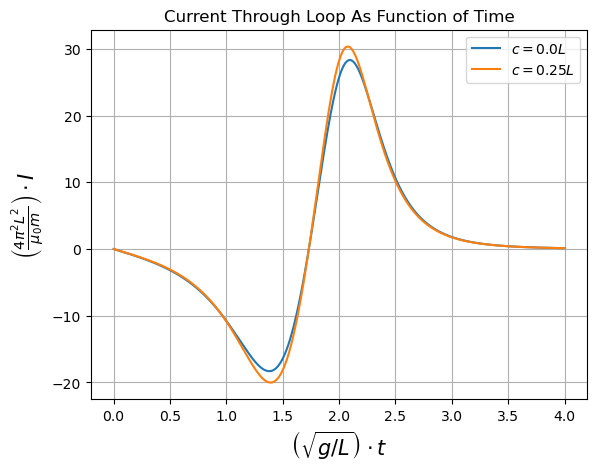

In [29]:
plt.plot(t.cpu(),current.cpu(), label=r'$c=0.0L$')
plt.plot(t.cpu(),current2.cpu(), label=r'$c=0.25L$')
plt.ylabel(r'$\left(\frac{4 \pi^2 L^2}{\mu_0 m}\right) \cdot I$', fontsize=15)
plt.xlabel(r'$\left(\sqrt{g/L}\right) \cdot t$', fontsize=15)
plt.grid()
plt.title('Current Through Loop As Function of Time')
plt.legend()

We see that if we offcenter the magnet drop it with an offset, we get a greater current through the current loop

# Using CPU

* Scipys `nquad` function

In [30]:
# Equivalent of the above PyTorch functions but with numpy and scipy
def solve_numpy(t,a,h0,R,c):
    return nquad(integrand_f, [[0,a], [0,2*np.pi], [0,1], [0,2*np.pi]],
                    args=(t,a,R,c,h0))[0]

def solve_multitimes_numpy(ts,a,h0,R,c):
    return np.vectorize(solve_numpy)(ts,a,h0,R,c)

In [31]:
t_numpy = np.linspace(0, 4, 10)
current_numpy = solve_multitimes_numpy(t_numpy,a=0.1,h0=1,R=1,c=0.0)
# only 10 integrals and it takes  30s

Compare points evaluated using CPU to points evaluated using GPU

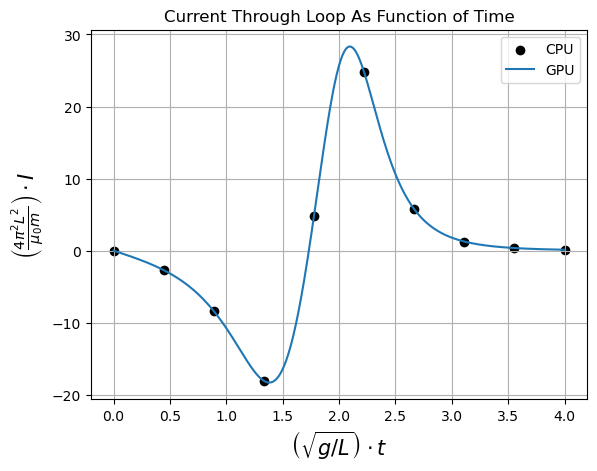

In [34]:
plt.scatter(t_numpy, current_numpy, color='k', label='CPU')
plt.plot(t.cpu(),current.cpu(), label='GPU')
plt.ylabel(r'$\left(\frac{4 \pi^2 L^2}{\mu_0 m}\right) \cdot I$', fontsize=15)
plt.xlabel(r'$\left(\sqrt{g/L}\right) \cdot t$', fontsize=15)
plt.grid()
plt.title('Current Through Loop As Function of Time')
plt.legend()